# Optimal Trajectory Planning for a Robotic Arm

## Module 1: Imports and Setup

This module imports the libraries needed for the project. NumPy is used for efficient numerical calculations with arrays. Matplotlib allows us to plot and visualize the robot arm’s motion. The SciPy optimization library provides the tools to solve the trajectory optimization problem. Lastly, typing helps with making function inputs and outputs clearer through type hints. These imports set up the environment to run all computations and visualizations.

In [ ]:
# Module 1: Imports and Setup
# ---------------------------

# Import essential libraries for math, optimization, and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Tuple

# You only need to import libraries once at the beginning of your project.


## Module 2: Forward Kinematics

Forward kinematics calculates the position of the robotic arm’s end-effector based on the joint angles. For our 2-link planar arm, we use trigonometric functions to find the (x, y) coordinates by summing the contributions from each link. This calculation is essential because it lets us understand where the arm will reach given certain joint angles, which is important for planning and visualization.

In [ ]:
# Module 2: Forward Kinematics
# ----------------------------

def forward_kinematics(q: np.ndarray, L: Tuple[float, float] = (1.0, 1.0)) -> np.ndarray:
    """
    Compute the 2D position (x, y) of the end-effector of a 2-link planar robotic arm.

    Args:
        q: Array of two joint angles [theta1, theta2] in radians.
        L: Tuple of link lengths (default: 1.0, 1.0).

    Returns:
        np.ndarray: The (x, y) coordinates of the end effector.
    """
    theta1, theta2 = q
    x = L[0] * np.cos(theta1) + L[1] * np.cos(theta1 + theta2)
    y = L[0] * np.sin(theta1) + L[1] * np.sin(theta1 + theta2)
    return np.array([x, y])


## Module 3: Minimum Jerk Cost Function

The cost function measures how smooth a trajectory is by calculating the jerk — the rate of change of acceleration. Minimizing jerk helps produce natural, smooth robot movements that reduce mechanical stress. We approximate jerk using finite differences over discrete time steps and sum the squared jerk values for both joints along the entire trajectory. This cost function guides the optimizer to find a smooth path.

In [ ]:
# Module 3: Minimum Jerk Cost Function
# ------------------------------------

def minimum_jerk_cost(q_flat: np.ndarray, N: int, dt: float) -> float:
    """
    Calculate the total jerk cost (sum of squared 3rd derivatives) for a trajectory.

    Args:
        q_flat: Flattened array of joint angles over time (shape: N*2).
        N: Number of discrete time points.
        dt: Time step size.

    Returns:
        float: The scalar cost representing trajectory smoothness.
    """
    q = q_flat.reshape(N, 2)
    jerk_cost = 0.0
    for i in range(3, N):
        # Third finite difference approximates jerk
        jerk = (q[i] - 3*q[i-1] + 3*q[i-2] - q[i-3]) / (dt ** 3)
        jerk_cost += np.sum(jerk ** 2)
    return jerk_cost


## Module 4: Constraints for Optimization

This module ensures the trajectory starts and ends exactly at specified joint positions. These boundary constraints are crucial because they define where the robot begins and where it should end up. Without these, the optimizer might find smooth but irrelevant trajectories. The constraints are written as functions that the optimizer tries to satisfy exactly, forcing the start and end joint angles to match the desired values.

In [ ]:
# Module 4: Trajectory Constraints
# --------------------------------

def trajectory_constraints(q_flat: np.ndarray, q_start: np.ndarray, q_end: np.ndarray, N: int) -> list:
    """
    Enforce start and end joint positions for the trajectory.

    Args:
        q_flat: Flattened joint angles array over time.
        q_start: Starting joint angles (2 elements).
        q_end: Ending joint angles (2 elements).
        N: Number of time steps.

    Returns:
        list: Constraints as residuals that optimizer tries to make zero.
    """
    q = q_flat.reshape(N, 2)
    # Constraints: initial and final joint positions must match specified values
    return [
        *(q[0] - q_start),  # Start pose
        *(q[-1] - q_end)    # End pose
    ]


## Module 5: Optimization and Visualization

Here we perform the actual trajectory optimization using the cost and constraints from previous modules. The optimizer begins with a simple linear guess between start and end positions and iteratively improves it to minimize jerk while respecting constraints. After finding the optimal joint trajectories, we visualize the robot arm’s movement over time by plotting the arm’s links at several points along the trajectory. This visualization helps verify that the path looks smooth and physically reasonable.

Iteration limit reached    (Exit mode 9)
            Current function value: 12.117386020377644
            Iterations: 100
            Function evaluations: 21301
            Gradient evaluations: 101


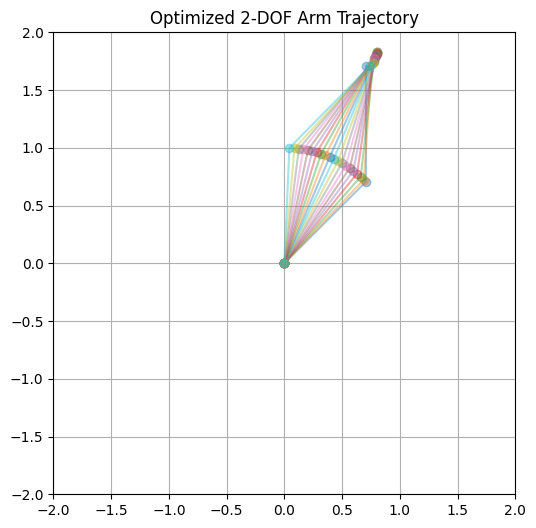

In [ ]:
# Module 5: Optimization and Visualization
# ----------------------------------------

def optimize_trajectory(q_start: np.ndarray, q_end: np.ndarray, N: int = 100, dt: float = 0.05) -> np.ndarray:
    """
    Optimize joint trajectories to minimize jerk given start/end positions.

    Args:
        q_start: Initial joint angles in radians.
        q_end: Final joint angles in radians.
        N: Number of discrete time steps.
        dt: Time step duration.

    Returns:
        np.ndarray: Optimized joint trajectories (N x 2).
    """
    # Initial guess: linear interpolation between start and end
    q_guess = np.linspace(q_start, q_end, N)
    q_flat = q_guess.flatten()

    constraints = {
        'type': 'eq',
        'fun': trajectory_constraints,
        'args': (q_start, q_end, N)
    }

    result = minimize(
        minimum_jerk_cost,
        q_flat,
        args=(N, dt),
        constraints=constraints,
        method='SLSQP',
        options={'disp': True}
    )

    q_opt = result.x.reshape(N, 2)
    return q_opt


def plot_trajectory(q_traj: np.ndarray, L: Tuple[float, float] = (1.0, 1.0)):
    """
    Visualize the 2-link arm movement along the optimized trajectory.

    Args:
        q_traj: Joint angles over time (N x 2).
        L: Link lengths (default 1.0, 1.0).
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    for q in q_traj[::5]:  # Plot every 5th frame to reduce clutter
        joint1 = np.array([0, 0])
        joint2 = L[0] * np.array([np.cos(q[0]), np.sin(q[0])])
        end_effector = joint2 + L[1] * np.array([np.cos(q[0] + q[1]), np.sin(q[0] + q[1])])
        xs = [joint1[0], joint2[0], end_effector[0]]
        ys = [joint1[1], joint2[1], end_effector[1]]
        ax.plot(xs, ys, 'o-', alpha=0.4)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title("Optimized 2-DOF Arm Trajectory")
    ax.set_aspect('equal')
    plt.grid()
    plt.show()


# Example usage:

q_start = np.radians([45, 45])    # Start joint angles (degrees to radians)
q_end = np.radians([90, -45])     # End joint angles

N = 100      # Number of discrete time points
dt = 0.05    # Time step duration (seconds)

q_opt = optimize_trajectory(q_start, q_end, N=N, dt=dt)
plot_trajectory(q_opt)
